In [1]:
import chess
import random
from IPython.display import clear_output, display
import time
import numpy as np
import itertools

C = np.sqrt(2)

In [2]:
class Node:
    def __init__(self, turn, action=None, parent=None):
        self.turn = turn
        self.action = action
        self.utility = 0
        self.n_playthrough = 0
        self.parent = parent
        self.children = list()


In [3]:
piece_value_map = {
    chess.PAWN: 100,
    chess.KNIGHT: 300,
    chess.BISHOP: 300,
    chess.ROOK: 500,
    chess.QUEEN: 900,
    chess.KING: 10000
}

In [34]:
from functools import lru_cache

def select(tree, board):
    while tree.children:
        tree = max(tree.children, key=lambda k: UCB1(k.utility, k.n_playthrough, k.parent.n_playthrough))
        board.push(tree.action)

    return tree

def expand(leaf, board):
    assert not leaf.children, 'This guy is not a leaf'
    
    if board.legal_moves:
        all_moves = list(board.legal_moves)
        
#         s = 3
#         if len(all_moves) < s:
#             s = len(all_moves)

#         rng = np.random.default_rng()
#         moves = rng.choice(all_moves, size=s)

        for move in all_moves:
            leaf.children.append(Node(turn=board.turn, action=move, parent=leaf))
        return leaf.children
    # if the current node is checkmated, i.e. no legal moves
    # then return the current node
    return [leaf]

# def simulate(board):
#     _board = board.copy()
#     while not _board.is_game_over():
#         move = max(_board.legal_moves, key=lambda x: eval_move(_board, x))
            
#         _board.push(move)

#         # simulate would take forever without this if statement
#         # basically the game would go on forever with 2 kings moving around without this check
#         if _board.has_insufficient_material(_board.turn) or _board.can_claim_fifty_moves():
#             return not _board.turn

#     return _board.outcome().winner


def simulate(board):
    if board.is_game_over():
        return board.outcome().winner
    
    # simulate would take forever without this if statement
    # basically the game would go on forever with 2 kings moving around without this check
    if board.has_insufficient_material(board.turn) or board.can_claim_fifty_moves():
        return not board.turn 
        
    move = max(board.legal_moves, key=lambda x: eval_move(board, x))

    board.push(move)

    result = simulate(board)
    
    board.pop()
    
    return result


def eval_move(board, move):
    move_score = 0
    move_piece = board.piece_type_at(move.from_square)
    capture_piece = board.piece_type_at(move.to_square)
    
    if capture_piece:
        move_score = 10 * piece_value_map[capture_piece] - piece_value_map[move_piece]
    
    if move.promotion:
        move_score += piece_value_map[move.promotion]
    
    enemy_pawn_squares = board.pieces(chess.PAWN, not board.turn)
    attacked_by_pawns = list(itertools.chain.from_iterable(map(board.attacks, enemy_pawn_squares)))
    if move.to_square in attacked_by_pawns:
        move_score -= piece_value_map[move_piece]
    
    return move_score

def back_prop(result, child):
    while child:
        child.n_playthrough += 1
        
        if result == child.turn:
            child.utility += 1
        
        child = child.parent


@lru_cache(maxsize=10000)
def UCB1(U_n, N_n, P_n):
    return U_n/N_n + C*np.sqrt(np.log(P_n)/N_n)

class MonteCarloAgent:
    
    # main function for the Monte Carlo Tree Search
    def monte_carlo_tree_search(self, board):
#         import concurrent.futures
        tree = Node(board.turn)
        for _ in range(1000):
            leaf = select(tree, board)
            
            children = expand(leaf, board)
            
            results = list()
            
            for child in children:
                if child is leaf:
                    results.append(simulate(board))
                    continue
                board.push(child.action)
                results.append(simulate(board))
                board.pop()
            
            while board.move_stack:
                board.pop()
            
            for result, child in zip(results, children):
                back_prop(result, child)
            
        leaf = select(tree, board)
        while leaf:
            print(leaf.turn)
            leaf = leaf.parent
            
        return max(tree.children, key=lambda k: k.n_playthrough).action, tree.n_playthrough
    


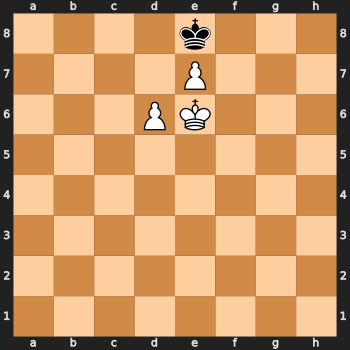

'True'

'n_playthrough=0'

True
True


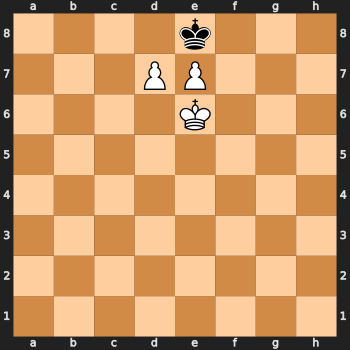

Outcome(termination=<Termination.CHECKMATE: 1>, winner=True)

'n_playthrough=3164'

In [35]:
import cProfile
import pstats
import chess.svg

SCENARIO_1 = '4k3/4P3/3PK3/8/8/8/8/8 w - - 0 1'
SCENARIO_2 = '8/3k4/8/8/8/3K4/3R4/3R4 w - - 0 1'
SCENARIO_3 = 'r1bqk1nr/ppp1bppp/3p4/n3p3/2B1P3/2NP1N2/PPP2PPP/R1BQK2R w KQkq - 1 6'

agent = MonteCarloAgent()
n = 0
board = chess.Board(SCENARIO_1)

with cProfile.Profile() as pr:
    while not board.is_game_over():
        clear_output(wait=True)
        display(chess.svg.board(board, size=350))
        display(f'{board.turn}')
        display(f'n_playthrough={n}')
        if board.turn:
            action, n = agent.monte_carlo_tree_search(board.copy(stack=False))
        else:
            action = random.choice(list(board.legal_moves))
        board.push(action)

display(chess.svg.board(board, size=350))
display(board.outcome())
display(f'n_playthrough={n}')


In [95]:
display(f'n_playthrough={n}')

stats = pstats.Stats(pr)
stats.sort_stats(pstats.SortKey.TIME)
stats.print_stats()

'n_playthrough=4118'

         301653825 function calls (301251299 primitive calls) in 160.678 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  8409606   16.592    0.000   35.021    0.000 <ipython-input-93-743d5fa52f71>:65(eval_move)
  7743368   12.047    0.000   12.047    0.000 C:\Users\engli\anaconda3\lib\site-packages\chess\__init__.py:753(_attackers_mask)
 12724954    9.381    0.000   20.875    0.000 C:\Users\engli\anaconda3\lib\site-packages\chess\__init__.py:1650(generate_pseudo_legal_moves)
 12348615    8.846    0.000   62.628    0.000 C:\Users\engli\anaconda3\lib\site-packages\chess\__init__.py:3488(generate_legal_moves)
  1484384    7.764    0.000   21.601    0.000 C:\Users\engli\anaconda3\lib\site-packages\chess\__init__.py:2140(push)
 21287404    7.645    0.000    7.645    0.000 C:\Users\engli\anaconda3\lib\site-packages\chess\__init__.py:683(piece_type_at)
 11271155    6.482    0.000   24.967    0.000 C:\Users\engli\anaconda3\lib\si

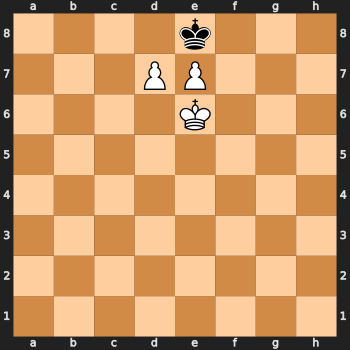

In [56]:
b = chess.Board('4k3/3PP3/4K3/8/8/8/8/8')
display(chess.svg.board(b, size=350))


In [96]:
board.outcome()


Outcome(termination=<Termination.FIVEFOLD_REPETITION: 5>, winner=None)